# Sequential Monte Carlo with two gaussians

Sampling from $n$-dimensional distributions with multiple peaks with a standard Metropolis-Hastings algorithm can be difficult, if not impossible, as the Markov chain often gets stuck in either of the minima.

This problem can be avoided by running many (`n_chains`) Markov chains in parallel for (`n_steps`) steps. To speed this process up we do not sample right away from the posterior distribution, but rather from an intermediate distribution that is similar to the previous distribution. Once the sampling for all the chains is finished, the algorithm enters a 'transitional stage'.

In this stage the similarity between the intermediate distributions is evaluated by a tempering parameter (`beta`), which is automatically determined from the sampling results (coefficient of variation - COV) from the previous intermediate distribution. If the COV is high the cooling is slow, resulting in small steps in `beta` and vice versa.
Also based on the parameter distributions the `MultivariateProposal` is updated and new seed points for the following Markov chains are determined. The end points of the Markov chains with the highest likelihoods are chosen as new seed-points for the Markov chains of the next sampling stage.

So the sampling of the intermediate distributions is repeated until `beta` $\ge$ 1, which means that the posterior distribution is reached. The final samples, _i.e_ those stored in the `trace`, will be taken exclusively from this final stage and the number of samples will equal `n_chains` $\times$  `n_steps`.

In [1]:
import pymc3 as pm
import numpy as np
from pymc3.step_methods import smc
import theano.tensor as tt
from matplotlib import pyplot as plt
from tempfile import mkdtemp
import shutil
%matplotlib inline

test_folder = mkdtemp(prefix='SMC_TEST')

The number of Markov chains and the number of steps each Markov chain is sampling has to be defined, as well as the `tune_interval` and the number of processors to be used in the parallel sampling. In this very simple example using only one processor is faster than forking the interpreter. However, if the calculation cost of the model increases it becomes more efficient to use many processors.

In [2]:
n_chains = 100
n_steps = 50
tune_interval = 10
n_jobs = 1

Define the number of dimensions for the multivariate gaussians, their weights and the covariance matrix. 

In [3]:
n = 4

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1
w2 = (1 - w1)

The PyMC3 model.  Note that we are making two gaussians, where one has `w1` (90%) of the mass:

In [4]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return tt.log(w1 * tt.exp(log_like1) + w2 * tt.exp(log_like2))


with pm.Model() as ATMIP_test:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1),
                   transform=None)
    llk = pm.Potential('llk', two_gaussians(X))

Note: In contrast to other pymc3 samplers here we have to define a random variable `like` that contains the model likelihood. The likelihood has to be stored in the sampling traces along with the model parameter samples, in order to determine the coefficient of variation [COV] in each transition stage.

Finally, we initialise the sampler and execute the sampling:

In [5]:
trace = smc.sample_smc(
    n_steps=n_steps,
    n_chains=n_chains,
    tune_interval=tune_interval,
    n_jobs=n_jobs,
    progressbar=False,
    stage=0,
    homepath=test_folder,
    model=ATMIP_test)

/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/smc.py:477: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/smc.py:120: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.010674 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.030207 Stage: 2
Initialising chain traces ...
Sampling ...
Beta: 0.063913 Stage: 3
Initialising chain traces ...
Sampling ...
Beta: 0.147236 Stage: 4
Initialising chain traces ...
Sampling ...
Beta: 0.331775 Stage: 5
Initialising chain traces ...
Sampling ...

Note: Complex models run for a long time and might stop for some reason during the sampling. In order to restart the sampling in the stage when the sampler stopped, set the stage argument to the right stage number(`stage=4`). The `rm_flag` determines whether existing results are deleted - there is NO additional warning, so the user should pay attention to that one! 

Plotting the results using the traceplot:

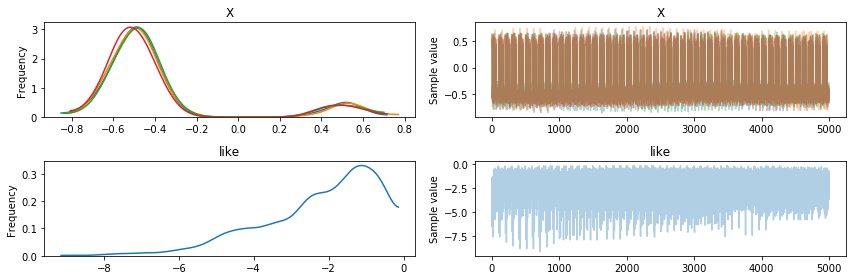

In [6]:
pm.traceplot(trace);

Finally, we delete the sampling result folder. This folder may occupy significant disc-space (Gigabytes), depending on the number of sampling parameters for complex models. So we advice the user to check in advance if there is enough space on the disc.

In [7]:
shutil.rmtree(test_folder)